<a href="https://colab.research.google.com/github/alinemls/datasets/blob/main/Iris_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação de Bibliotecas

In [88]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from scipy.stats import randint
from mlxtend.plotting import plot_confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, cohen_kappa_score as kappa, confusion_matrix

v_variation = 0.15

num_grupos = 3      # 0(pela classe)

qtd_faixas = 5      # 0(automático) 

n_base = "iris"

#t_sel_att = "Regressao MLP"
# Regressao MLP
# Classificador MLP
# Mutual Info

#qtd_teste = 0.3 # Porcentagem de dados para teste no seletor de atributos supervisionado

##Preparação e Carregamento das bases

In [ ]:
scaler = StandardScaler()
trans = MinMaxScaler()

if n_base == "iris":
  bb = sns.load_dataset(n_base)

if n_base == 'seeds':
  bb = pd.read_csv("/content/drive/MyDrive/bases/seeds.csv",sep=",")

if n_base == 'glass':
  bb = pd.read_csv("/content/drive/MyDrive/bases/glass.csv",sep=",")

if n_base == 'wine':
  bb = pd.read_csv("/content/drive/MyDrive/bases/wine.csv",sep=",")

if n_base == 'cancer_mama':
  bb = pd.read_csv("/content/drive/MyDrive/bases/cancermama.csv",sep=",")
  bb = bb.iloc[: , :-1]
  col_list = list(bb)
  columns_titles = ['id', 'fractal_dimension_worst', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'diagnosis']
  bb=bb.reindex(columns=columns_titles)


#pin = sns.load_dataset('penguins')
#iris.head()
#pin.head()
#pin.tail()
base_original = bb
print("=========> Base Original <=========\n",base_original)

#print("Descrição dos Dados:\n", base_original.describe())

# --> Remove nulls <--
data = base_original.dropna()
data = data.reset_index(drop = True)


if(num_grupos == 0): #<><><><><> Se a classe for o grupo <><><><><><>
  #print(data.columns[-1])
  #data[data.columns[-1]] = data[data.columns[-1]].map({0:'X'}, na_action='ignore')
  data[data.columns[-1]].replace(0, 'X', inplace = True)
  att_classe = data.iloc[: , -1]
  att_classe = att_classe.unique()
  qtd_classes = 0
  for item in att_classe:
    #print(item,i)
    #data.replace(to_replace=item, value=str(i))
    #data["species"].replace("setosa","kjkj", regex=True)
    data[data.columns[-1]].replace({item: qtd_classes}, inplace=True)
    qtd_classes = qtd_classes + 1
  data.columns = [*data.columns[:-1], 'grupo']
else:
  # --> Apagar Colunas classe <--
  if num_grupos > 0:
    #att_classe = "species"
    data = data.iloc[: , :-1] # Apaga o atributo classe (última coluna)


# Apaga o atributo ID
if 'ID' in data.columns:    
  data = data.drop(columns=["ID"]) 
if 'id' in data.columns: 
  data = data.drop(columns=["id"]) 

base_original = data

# --> Normalização <--
colunas = list(data.columns.values)
#print (colunas) 
n_normalizacao = "Sem Normalização"
if(p_normalizacao == 1):
  data = scaler.fit_transform(data)
  n_normalizacao = "Desvio Padrão"
if(p_normalizacao == 2):
  data = trans.fit_transform(data)
  n_normalizacao = "Escala 0-1"

data = pd.DataFrame(data, columns = colunas)

print("\n\n\n")
print("=========> Base Modificada <=========\n",data)
#print("Descrição dos Dados:\n", data.describe())


In [89]:
#df = pd.read_csv('https://raw.githubusercontent.com/webalysson/datasets/main/Iris.csv')
#df.head(5)

,Id,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [90]:
#df.drop(labels=['Id'], axis=1, inplace=True, errors='ignore')

In [91]:
#df.head(5)

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [92]:
# Agrupamento pela identificação completa da planta
#df.groupby('Species').size()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

### Contrução do Modelo

In [93]:
# definir qual dataset será usado
dataset_model = df.copy()

In [94]:
X = dataset_model.drop(columns=['Species']).values

In [95]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [96]:
# Transformação do atributo categórico em numérico
le = preprocessing.LabelEncoder()
le.fit(dataset_model.Species)
y = le.transform(dataset_model['Species'].values)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [97]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 50, 1: 50, 2: 50}

In [98]:
# Dividindo o dataset em subconjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [99]:
print('X_train =>',X_train.shape)
print('X_test =>',X_test.shape)
print('Y_train =>',y_train.shape)
print('Y_test =>',y_test.shape)

X_train => (105, 4)
X_test => (45, 4)
Y_train => (105,)
Y_test => (45,)


In [100]:
# Modelo com DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(criterion='entropy')
clf_dt = clf_dt.fit(X_train, y_train)
y_predict_train = clf_dt.predict(X_train)
y_predict_test = clf_dt.predict(X_test)

In [101]:
X_test

array([[7.6, 3. , 6.6, 2.1],
       [6.7, 3.3, 5.7, 2.5],
       [7.1, 3. , 5.9, 2.1],
       [6.2, 3.4, 5.4, 2.3],
       [6.4, 2.7, 5.3, 1.9],
       [6.5, 3. , 5.2, 2. ],
       [6.3, 2.8, 5.1, 1.5],
       [6. , 3.4, 4.5, 1.6],
       [6.9, 3.1, 4.9, 1.5],
       [5.9, 3. , 4.2, 1.5],
       [5. , 3.6, 1.4, 0.2],
       [5.5, 2.4, 3.7, 1. ],
       [6.4, 3.2, 4.5, 1.5],
       [5.8, 2.7, 5.1, 1.9],
       [4.8, 3.4, 1.9, 0.2],
       [5.1, 3.8, 1.5, 0.3],
       [6. , 2.9, 4.5, 1.5],
       [5.6, 2.8, 4.9, 2. ],
       [5.5, 4.2, 1.4, 0.2],
       [4.8, 3. , 1.4, 0.3],
       [6.3, 3.3, 4.7, 1.6],
       [5.5, 2.3, 4. , 1.3],
       [4.4, 3. , 1.3, 0.2],
       [7.2, 3.2, 6. , 1.8],
       [6.3, 2.7, 4.9, 1.8],
       [6. , 2.7, 5.1, 1.6],
       [4.4, 2.9, 1.4, 0.2],
       [6.9, 3.2, 5.7, 2.3],
       [7.7, 2.8, 6.7, 2. ],
       [6. , 2.2, 4. , 1. ],
       [6.6, 2.9, 4.6, 1.3],
       [7.2, 3. , 5.8, 1.6],
       [7.2, 3.6, 6.1, 2.5],
       [5.2, 4.1, 1.5, 0.1],
       [6.4, 2

In [102]:
y_predict_all = clf_dt.predict(X)

In [103]:
df['y'] = y_predict_all

In [104]:
df.head(10)

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species,y
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0
5,5.4,3.9,1.7,0.4,Iris-setosa,0
6,4.6,3.4,1.4,0.3,Iris-setosa,0
7,5.0,3.4,1.5,0.2,Iris-setosa,0
8,4.4,2.9,1.4,0.2,Iris-setosa,0
9,4.9,3.1,1.5,0.1,Iris-setosa,0


In [105]:
df.groupby('y').size()

y
0    50
1    52
2    48
dtype: int64

In [106]:
# Checando a acurácia manualmente
print("Acurácia manual: %.2f" % np.mean(y_predict_test == y_test))

Acurácia manual: 0.96


In [107]:
# Avaliação
accuracy = metrics.accuracy_score(y_test, y_predict_test)
print("DecisionTree")
print("Accuracy: %.2f" % (accuracy))
#print("Coeficiente de Kappa: %.2f" % (kappa(y_test, clf_dt.predict(X_test))) )
#print("F1 Score train: %.2f" % f1_score(y_train, y_predict_train))
#print("F1 Score test: %.2f" % f1_score(y_test, y_predict_test))

DecisionTree
Accuracy: 0.96


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa3d80aab10>)

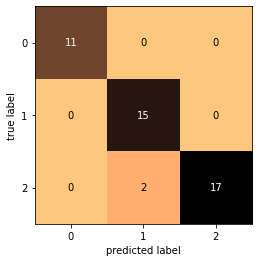

In [108]:
# Gerar a matrix de confusão NxN
conf_mat = confusion_matrix(y_test, y_predict_test)
plot_confusion_matrix(conf_mat,figsize=(12,4),cmap='copper_r')

In [109]:
#!pip install mlxtend --upgrade

[Text(0.375, 0.9285714285714286, 'Petal_Width <= 0.8\nentropy = 1.579\nsamples = 105\nvalue = [39, 35, 31]\nclass = Iris-setosa'),
 Text(0.25, 0.7857142857142857, 'entropy = 0.0\nsamples = 39\nvalue = [39, 0, 0]\nclass = Iris-setosa'),
 Text(0.5, 0.7857142857142857, 'Petal_Width <= 1.6\nentropy = 0.997\nsamples = 66\nvalue = [0, 35, 31]\nclass = Iris-setosa'),
 Text(0.25, 0.6428571428571429, 'Petal_Length <= 5.25\nentropy = 0.191\nsamples = 34\nvalue = [0, 33, 1]\nclass = Iris-setosa'),
 Text(0.125, 0.5, 'entropy = 0.0\nsamples = 33\nvalue = [0, 33, 0]\nclass = Iris-setosa'),
 Text(0.375, 0.5, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = Iris-setosa'),
 Text(0.75, 0.6428571428571429, 'Petal_Length <= 5.05\nentropy = 0.337\nsamples = 32\nvalue = [0, 2, 30]\nclass = Iris-setosa'),
 Text(0.625, 0.5, 'Sepal_Width <= 2.9\nentropy = 0.811\nsamples = 8\nvalue = [0, 2, 6]\nclass = Iris-setosa'),
 Text(0.5, 0.35714285714285715, 'entropy = 0.0\nsamples = 4\nvalue = [0, 0, 4]\nclass = 

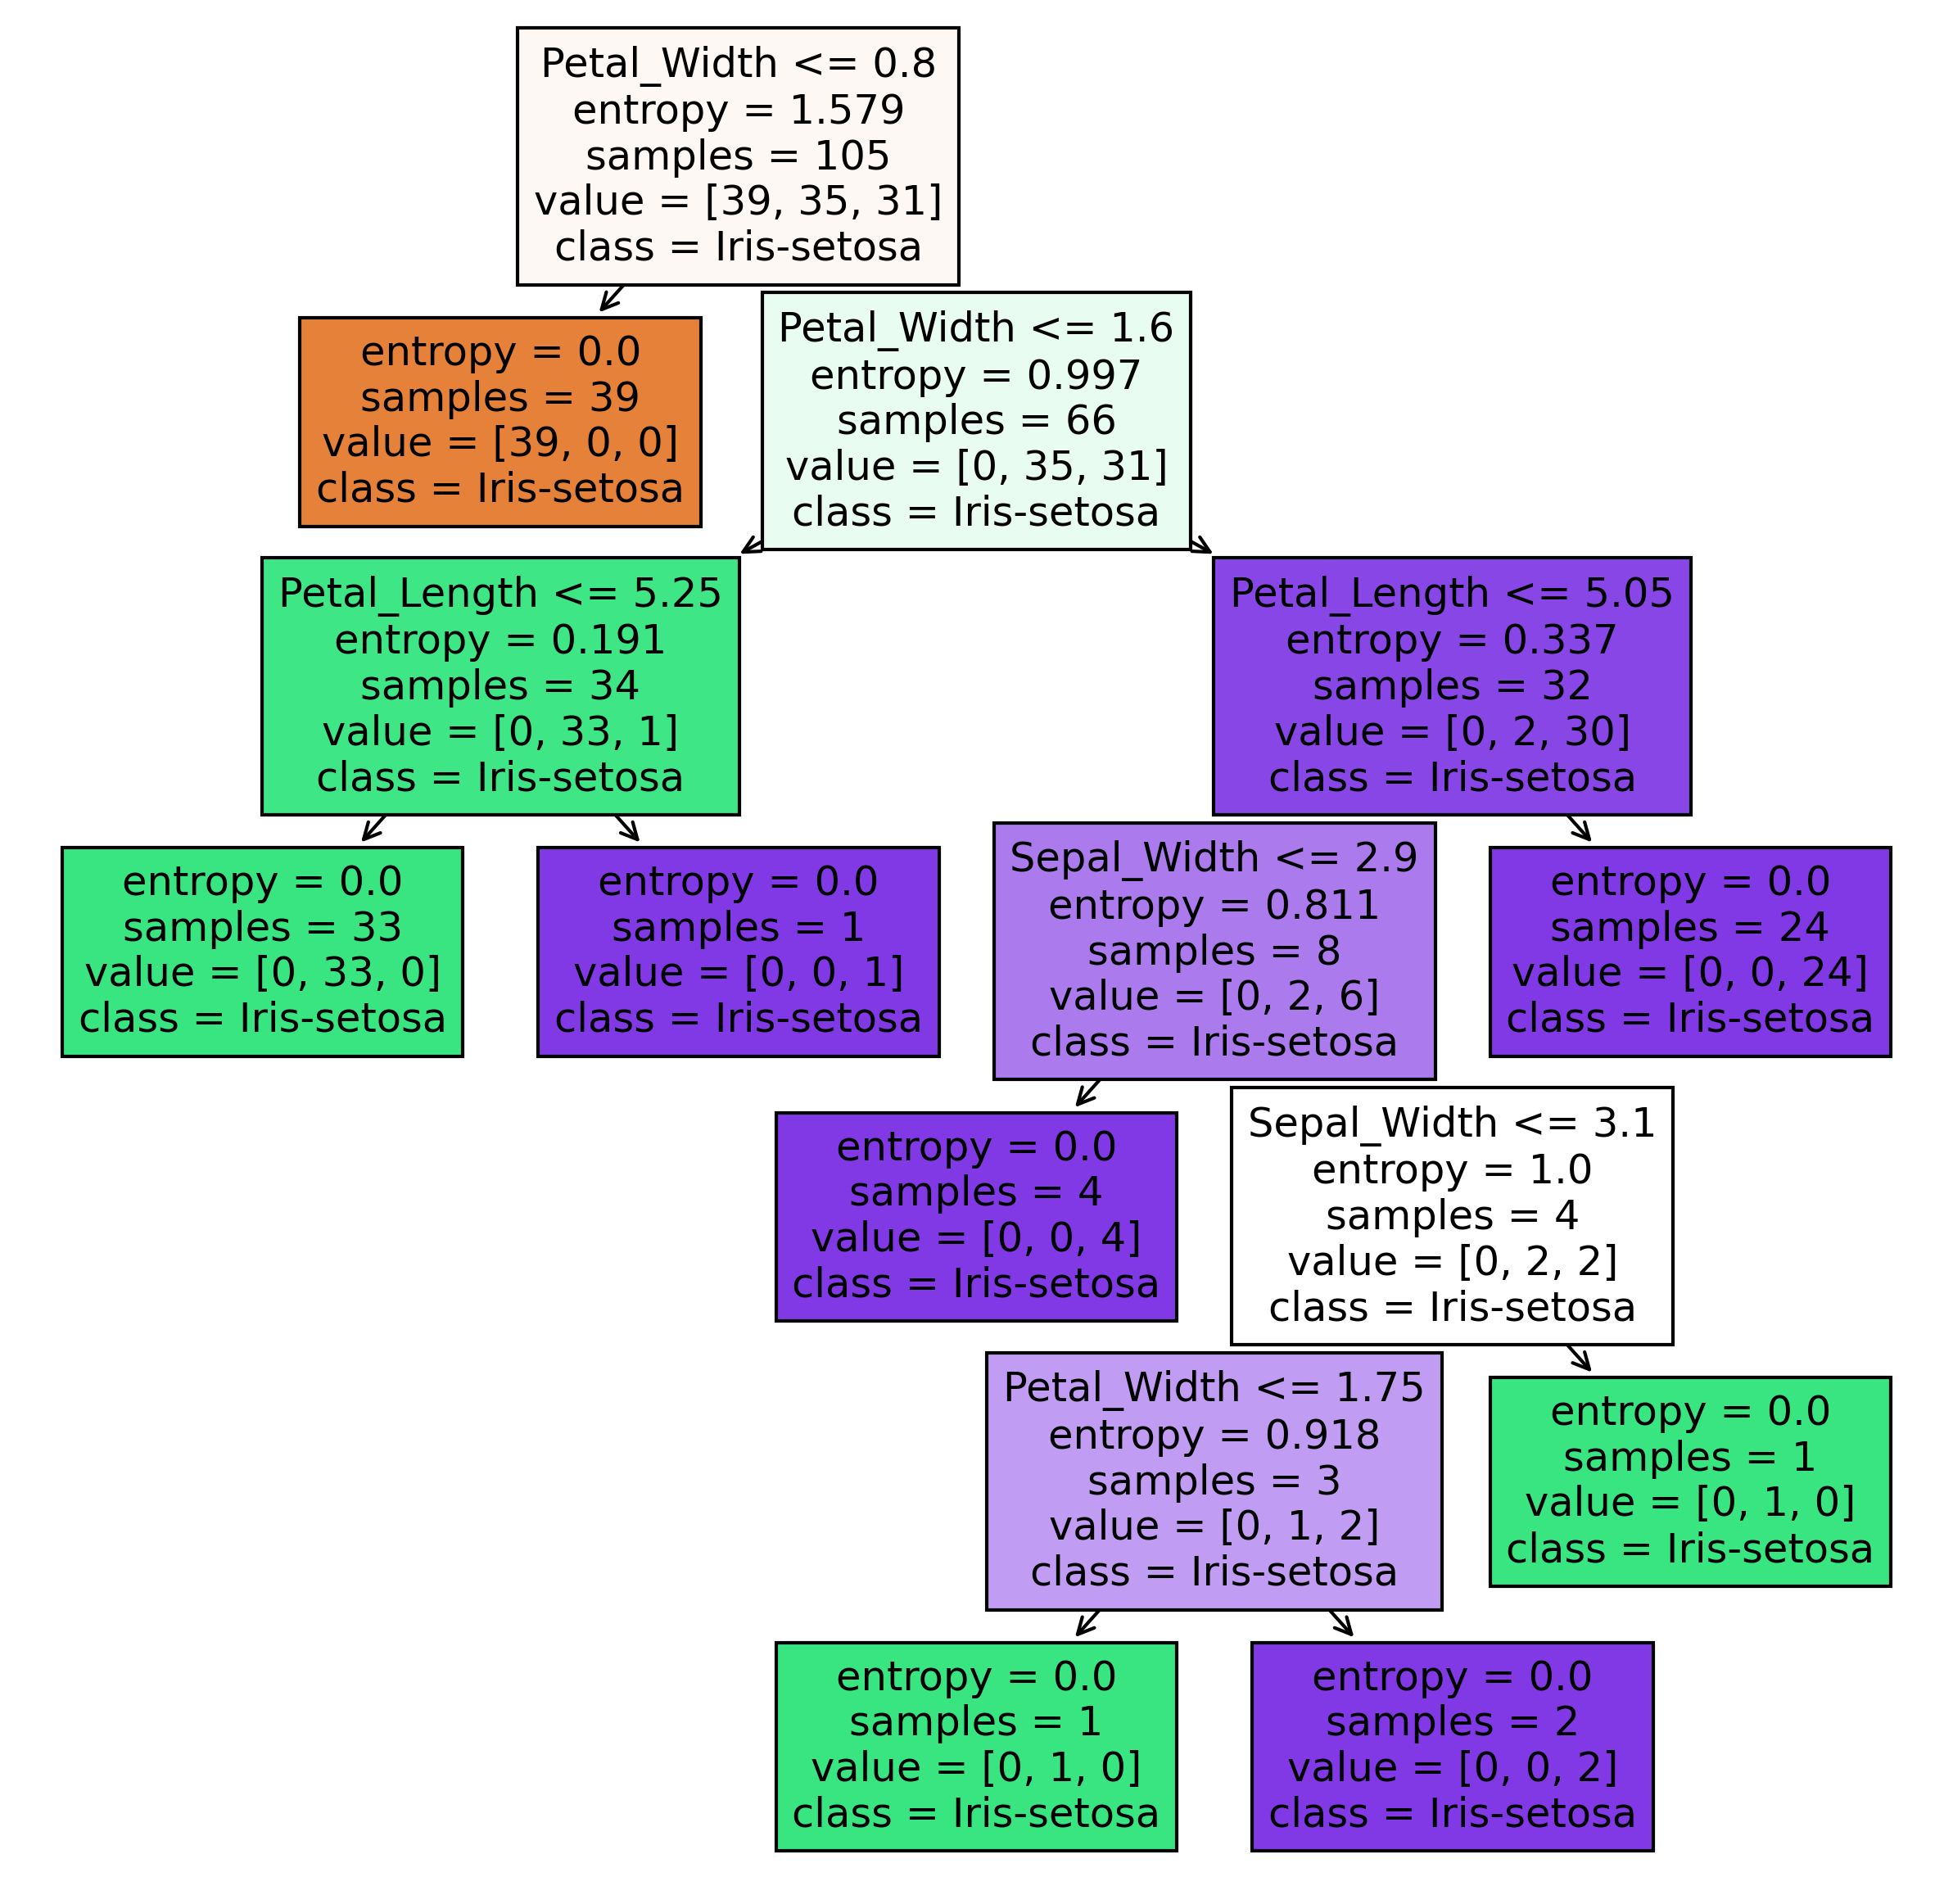

In [110]:
# Gerar a árvore para exibição

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(clf_dt,
               feature_names = df.columns, 
               #class_names=['a','b'],
               class_names=df.Species,
               filled = True
               )
# fig.savefig('tree.png')


In [111]:
!pip install graphviz

In [112]:
import graphviz

In [113]:
dataset_model.columns.drop('Species')

Index(['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'], dtype='object')

In [114]:
dot_data = tree.export_graphviz(clf_dt, out_file=None, 
                      feature_names=dataset_model.columns.drop('Species'),  
                      class_names=df.Species,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
# graph
graph.render(filename="iris", view=True, format='png')

'iris.png'

In [115]:
from sklearn.tree import export_text
r = export_text(clf_dt, feature_names=['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'])
print(r)

|--- Petal_Width <= 0.80
|   |--- class: 0
|--- Petal_Width >  0.80
|   |--- Petal_Width <= 1.60
|   |   |--- Petal_Length <= 5.25
|   |   |   |--- class: 1
|   |   |--- Petal_Length >  5.25
|   |   |   |--- class: 2
|   |--- Petal_Width >  1.60
|   |   |--- Petal_Length <= 5.05
|   |   |   |--- Sepal_Width <= 2.90
|   |   |   |   |--- class: 2
|   |   |   |--- Sepal_Width >  2.90
|   |   |   |   |--- Sepal_Width <= 3.10
|   |   |   |   |   |--- Petal_Width <= 1.75
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Petal_Width >  1.75
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- Sepal_Width >  3.10
|   |   |   |   |   |--- class: 1
|   |   |--- Petal_Length >  5.05
|   |   |   |--- class: 2



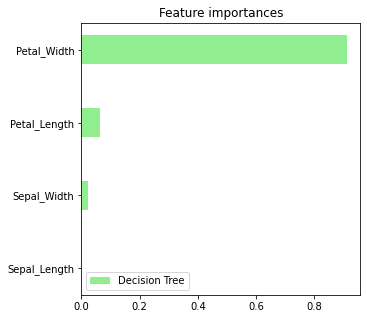

In [116]:
# Feature importances

feature_importance=pd.DataFrame({
    #'rfc':clf_rf.feature_importances_,
    'dt':clf_dt.feature_importances_
},index=dataset_model.drop(columns=['Species']).columns)
feature_importance.sort_values(by='dt',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(5,5))
#rfc_feature=ax.barh(index,feature_importance['rfc'],0.4,color='purple',label='Random Forest')
dt_feature=ax.barh(index+0.4,feature_importance['dt'],0.4,color='lightgreen',label='Decision Tree')
ax.set(yticks=index+0.4,yticklabels=feature_importance.index)
ax.set_title("Feature importances")
ax.legend()
plt.show()
